In [1]:
import sys
sys.path.insert(0, '/Users/hosseinb/projects/llm-orchestrated-computational-intelligence')

from pydantic import BaseModel
from utils import llm_service
import importlib

# Reload modules (run this cell again after making changes to source files)
importlib.reload(llm_service)

# Reload ACO specifically, then reload methods to pick up changes
from methods import aco
importlib.reload(aco)

import methods
importlib.reload(methods)

<module 'methods' from '/Users/hosseinb/projects/llm-orchestrated-computational-intelligence/src/methods/__init__.py'>

In [4]:

resp = llm_service.get_chat_completion(llm_service.Model.GPT_OSS.value, 
[
    {"role": "system", "content": "Hello, world! what do you think?"}, 
    {"role": "user", "content": "what is 2+2?"}
], 
max_tokens=200)
print(resp)

2 + 2 = 4.


In [5]:
class Answer(BaseModel):
    answer: int
    reason: str

resp = llm_service.get_chat_completion_structured(llm_service.Model.GLM_4_7.value, 
[
    {"role": "system", "content": "Hello, world! what do you think?"}, 
    {"role": "user", "content": "what is 2+2?"}
], 
Answer,
max_tokens=200)
resp

Answer(answer=4, reason='Basic arithmetic addition.')

# Test select_method

In [3]:
problem_info = """
Problem: Traveling Salesman Problem
Cities: 10
Distance Matrix:
[[  0,  29,  82,  46,  68,  52,  72,  42,  51,  55],
 [ 29,   0,  55,  46,  42,  43,  43,  23,  23,  31],
 [ 82,  55,   0,  68,  46,  55,  23,  43,  41,  29],
 [ 46,  46,  68,   0,  82,  15,  72,  31,  62,  42],
 [ 68,  42,  46,  82,   0,  74,  23,  52,  21,  46],
 [ 52,  43,  55,  15,  74,   0,  61,  23,  55,  31],
 [ 72,  43,  23,  72,  23,  61,   0,  42,  23,  31],
 [ 42,  23,  43,  31,  52,  23,  42,   0,  33,  15],
 [ 51,  23,  41,  62,  21,  55,  23,  33,   0,  29],
 [ 55,  31,  29,  42,  46,  31,  31,  15,  29,   0]]
Objective: Minimize total tour distance
Time Limit: lot of time is available(use ga)
Priority: Solution quality over speed
"""
from orchestrator.problem_parser import parse_problem
resp_p1 = parse_problem(problem_info)

{
  "content": {
    "n_cities": 10,
    "known_optimal": "not_specified",
    "distance_matrix": [
      [0, 29, 82, 46, 68, 52, 72, 42, 51, 55],
      [29, 0, 55, 46, 42, 43, 43, 23, 23, 31],
      [82, 55, 0, 68, 46, 55, 23, 43, 41, 29],
      [46, 46, 68, 0, 82, 15, 72, 31, 62, 42],
      [68, 42, 46, 82, 0, 74, 23, 52, 21, 46],
      [52, 43, 55, 15, 74, 0, 61, 23, 55, 31],
      [72, 43, 23, 72, 23, 61, 0, 42, 23, 31],
      [42, 23, 43, 31, 52, 23, 42, 0, 33, 15],
      [51, 23, 41, 62, 21, 55, 23, 33, 0, 29],
      [55, 31, 29, 42, 46, 31, 31, 15, 29, 0]
    ],
    "objective": "Minimize total tour distance",
    "time_limit": "not_specified",
    "priority": "Solution quality over speed"
  },
  "problem_type": "TSP"
}


In [4]:
from orchestrator.method_selector import select_method
result = select_method(problem_info, model=llm_service.Model.GPT_OSS.value)
# Check the LLM selection result
print("Selected Method:", result["selected_method"])
print("Parameters:", result["parameters"])
print("Reasoning:", result["reasoning"])

{
    "problem_type": "TSP",
    "selected_method": "ga",
    "reasoning": "The problem is a classic Traveling Salesman Problem with 10 cities. While Ant Colony Optimization is often the primary choice for routing problems, the user explicitly prefers a Genetic Algorithm and has ample time, allowing us to prioritize solution quality. GA with a permutation encoding is well‑suited for combinatorial optimization like TSP, and we can configure a relatively large population and many generations to explore the search space thoroughly.",
    "parameters": {
        "population_size": 200,
        "crossover_rate": 0.9,
        "mutation_rate": 0.05,
        "generations": 3000,
        "elitism": 5,
        "encoding": "permutation"
    }
, "backup_method": "aco",
  "confidence": 0.97}
Selected Method: ga
Parameters: {'population_size': 200, 'crossover_rate': 0.9, 'mutation_rate': 0.05, 'generations': 3000, 'elitism': 5, 'encoding': 'permutation'}
Reasoning: The problem is a classic Traveling

In [5]:
from problems import load_problem
problem = load_problem(resp_p1)
problem.distance_matrix

[[0, 29, 82, 46, 68, 52, 72, 42, 51, 55],
 [29, 0, 55, 46, 42, 43, 43, 23, 23, 31],
 [82, 55, 0, 68, 46, 55, 23, 43, 41, 29],
 [46, 46, 68, 0, 82, 15, 72, 31, 62, 42],
 [68, 42, 46, 82, 0, 74, 23, 52, 21, 46],
 [52, 43, 55, 15, 74, 0, 61, 23, 55, 31],
 [72, 43, 23, 72, 23, 61, 0, 42, 23, 31],
 [42, 23, 43, 31, 52, 23, 42, 0, 33, 15],
 [51, 23, 41, 62, 21, 55, 23, 33, 0, 29],
 [55, 31, 29, 42, 46, 31, 31, 15, 29, 0]]

In [6]:
from methods import get_method
# Get the method instance using the LLM's selection
method = get_method(result["selected_method"])

# Run the method with LLM-suggested parameters
result["parameters"].update({"n_ants": 2})
aco_result = method.run(problem, result["parameters"])

# Display results
print(f"Best Tour: {aco_result['best_solution']}")
print(f"Best Tour Length: {aco_result['best_fitness']:.2f}")
print(f"Computation Time: {aco_result['computation_time']:.2f}s")
print(f"Iterations: {aco_result['iterations_completed']}")

Best Tour: [np.int64(6), np.int64(2), np.int64(9), np.int64(7), np.int64(5), np.int64(3), np.int64(0), np.int64(1), np.int64(8), np.int64(4)]
Best Tour Length: 247.00
Computation Time: 9.12s
Iterations: 3000


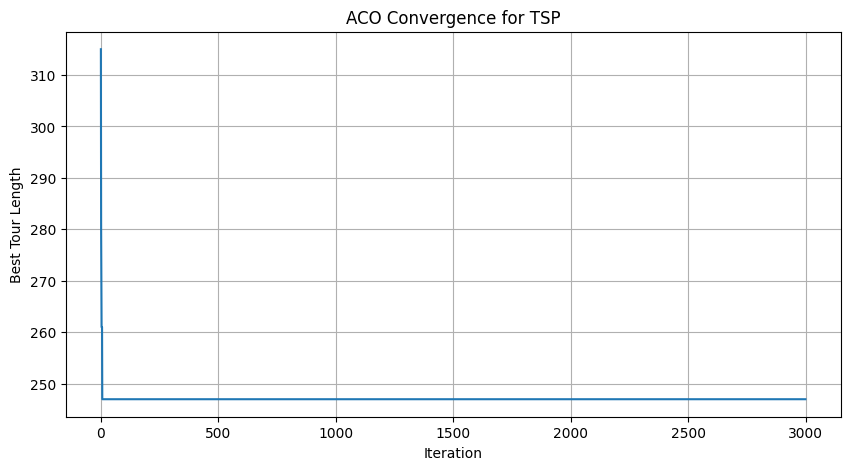

In [7]:
# Plot convergence curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(aco_result['convergence_history'])
plt.xlabel('Iteration')
plt.ylabel('Best Tour Length')
plt.title('ACO Convergence for TSP')
plt.grid(True)
plt.show()